# Imports

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Preprocessing

## Preprocessing imports

In [58]:
from sklearn.model_selection import train_test_split

In [60]:
# infile_dataset = open(f'data/low_q_binned_weights_1000.pkl', 'rb')
# infile_dataset = open(f'data/low_q_binned_weights_1000_new_samples.pkl', 'rb')
# infile_dataset = open(f'data/dataset_1_19_20_local.pkl', 'rb')
infile_dataset = open(f'data/low_q_binned_weights_big_interp.pkl', 'rb')

dataset_1 = pickle.load(infile_dataset)
infile_dataset.close()

In [65]:
# qkl_histograms = np.array([x['histogram_qkl'] for x in dataset_1])
qkl_histograms_interp = np.array([x['histogram_qkl_interp'] for x in dataset_1])
qkl_coefficients = np.array([[x['c9'], x['c10']] for x in dataset_1])

qkl_histograms, qkl_histograms_reserved = qkl_histograms_interp[:-10], qkl_histograms_interp[-9:]
qkl_coefficients, qkl_coefficients_reserved = qkl_coefficients[:-10], qkl_coefficients[-9:]

X_train, X_test, y_train, y_test = train_test_split(qkl_histograms, qkl_coefficients, test_size=0.25)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],X_test.shape[2], X_test.shape[3], 1)

## EDA

In [62]:
n_bins = 10
bin_edges_ql = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # l
]
bin_edges_kl = [
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]
bin_edges_qkl = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

bin_centres_3d = [(edges[:-1] + edges[1:]) / 2 for edges in bin_edges_qkl]

x, y, z = np.meshgrid(*bin_centres_3d)

<ipython-input-66-8ee3f9911a31>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


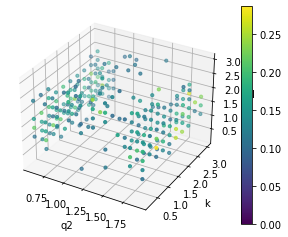

In [66]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

iii = 3
# ex_grid = qkl_histograms[iii]
ex_grid_interp = qkl_histograms_interp[iii]
# ex_grid_diff = ex_grid - ex_grid_interp

# im = ax.scatter(x, y, z, c = ex_grid_diff, s=np.where(ex_grid_diff > 1e-3, 10, 0))
# im = ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 1e-2, 10, 0))
im = ax.scatter(x, y, z, c = ex_grid_interp, s=np.where(ex_grid_interp > 10e-2, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

fig.colorbar(im)

fig.show()

# Model Creation and Evaluation

## ML Imports

In [67]:
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score

## Modelling

### 3D CNN

In [9]:
model_3d = keras.Sequential()

# Convolutional part
model_3d.add(layers.Conv3D(10, (3,3,3), activation='relu', input_shape=(10,10,10,1)))
model_3d.add(layers.MaxPool3D((2,2,2)))
model_3d.add(layers.Conv3D(20, (3,3,3), activation='relu'))

# Dense part
model_3d.add(layers.Dense(10, activation='relu'))
model_3d.add(layers.Flatten())
model_3d.add(layers.Dense(2, activation='linear'))

model_3d.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [23]:
history = model_3d.fit(
    X_train, 
    y_train,
    # batch_size=10,
    epochs=10,
    # validation_data=(x_test, y_test)
)

Epoch 1/10
24/24 [==============================] - 1s 21ms/step - loss: 0.0499 - mean_squared_error: 0.0499
Epoch 2/10
24/24 [==============================] - 1s 22ms/step - loss: 0.0583 - mean_squared_error: 0.0583
Epoch 3/10
24/24 [==============================] - 1s 22ms/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 4/10
24/24 [==============================] - 0s 20ms/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 5/10
24/24 [==============================] - 0s 20ms/step - loss: 0.0472 - mean_squared_error: 0.0472
Epoch 6/10
24/24 [==============================] - 1s 22ms/step - loss: 0.0505 - mean_squared_error: 0.0505
Epoch 7/10
24/24 [==============================] - 0s 20ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 8/10
24/24 [==============================] - 1s 21ms/step - loss: 0.0465 - mean_squared_error: 0.0465
Epoch 9/10
24/24 [==============================] - 0s 21ms/step - loss: 0.0547 - mean_squared_error: 0.0547
Epoch 10/10
24/24 [

In [24]:
pred = model_3d.predict(X_test)

print(f'R^2    - {r2_score(pred, y_test)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test[:,1])}')

R^2    - 0.6938491935473016
R^2(a) - 0.8966523022989807
R^2(b) - 0.49104609168128965


[[-0.309048    0.31930056]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
<ipython-input-25-e5bebaf0a16f>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


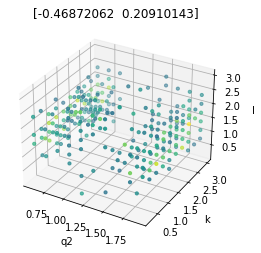

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

iii = 3
ex_grid = X_test[iii].reshape(10,10,10)

print(model_3d.predict(np.array([X_test[iii]])))

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 10e-2, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')
ax.set_title(y_test[iii])
fig.show()

#### Export model

In [38]:
model_3d.save('models/model_3d_10bins_5000n')


INFO:tensorflow:Assets written to: models/model_3d_10bins_5000n/assets


### 3D Dense

In [70]:
model_3d_dense = keras.Sequential()

# Dense part
model_3d_dense.add(layers.Dense(100, activation='relu'))
model_3d_dense.add(layers.Dense(100, activation='relu'))
model_3d_dense.add(layers.Flatten())
model_3d_dense.add(layers.Dense(2, activation='linear'))

model_3d_dense.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [71]:
history = model_3d_dense.fit(
    X_train, 
    y_train,
    # batch_size=10,
    epochs=10,
    # validation_data=(x_test, y_test)
)

Epoch 1/10
235/235 [==============================] - 6s 24ms/step - loss: 0.1362 - mean_squared_error: 0.1362
Epoch 2/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 3/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0426 - mean_squared_error: 0.0426
Epoch 4/10
235/235 [==============================] - 7s 28ms/step - loss: 0.0404 - mean_squared_error: 0.0404
Epoch 5/10
235/235 [==============================] - 6s 27ms/step - loss: 0.0376 - mean_squared_error: 0.0376
Epoch 6/10
235/235 [==============================] - 8s 33ms/step - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 7/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0368 - mean_squared_error: 0.0368
Epoch 8/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 9/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0367 - mean_squared_error: 0.0367
E

In [72]:
pred = model_3d_dense.predict(X_test)

print(f'R^2    - {r2_score(pred, y_test)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test[:,1])}')

R^2    - 0.8659084112425066
R^2(a) - 0.9319318924095659
R^2(b) - 0.7998849309012315


#### Export model

In [73]:
model_3d_dense.save('models/model_3d_dense_10bins_interp')

INFO:tensorflow:Assets written to: models/model_3d_dense_10bins_interp/assets


### 3D pdf classification

In [84]:
xxx = np.random.random((10000,3))
yyy = np.sum(xxx, axis=1)
yyy = np.round(yyy, 1)



xxx_train, xxx_test, yyy_train, yyy_test = train_test_split(xxx, yyy)

In [85]:
yyy

array([1.3, 1.1, 1.8, ..., 1.3, 1.5, 1.6])

# Verify with new data

In [74]:
sample_path = '/Users/oskar/MSci/new-physics/toy_data/flavio_tests/data/'
sample_filename = 'toy_data_c9_0.43_c10_0.17_2022_1_16_0.csv'
sample = pd.read_csv(sample_path + sample_filename, index_col=0)

sample_path = '/Users/oskar/MSci/new-physics/toy_data/wilson_regression/data/'
sample_filename_sm = 'low_q_with_weights.csv'
sample_sm = pd.read_csv(sample_path + sample_filename_sm)

In [75]:
n_bins = 10

bin_edges_qkl = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

values_3d_qkl, _ = np.histogramdd(
    sample_sm[['q2', 'k', 'l']].values[:5000],
    bins=bin_edges_qkl,
    # weights=sample_sm['scenario_8_w'].iloc[:5000],
    density=True
)

NameError: name 'model_3d' is not defined

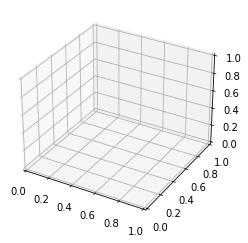

In [76]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ex_grid = values_3d_qkl
# ex_grid = qkl_histograms_reserved[]

# print(qkl_coefficients_reserved[])

print(model_3d.predict(np.array([ex_grid.reshape(10,10,10,1)])))

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 10e-2, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

fig.show()

# Error evaluation

In [ ]:
n_bins = 10

bin_edges_qkl = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

values_3d_qkl, _ = np.histogramdd(
    sample_sm[['q2', 'k', 'l']].values[:5000],
    bins=bin_edges_qkl,
    # weights=sample_sm['scenario_8_w'].iloc[:5000],
    density=True
)

model_3d.predict(np.array([ex_grid.reshape(10,10,10,1)]))


In [46]:
n_bins = 10
error_samples = 10_000
error_sample_size = 5000

bin_edges_qkl = [
    np.linspace(0.5, 2, n_bins+1),           # q2
    np.linspace(0, np.pi, n_bins+1),         # k
    np.linspace(0, np.pi, n_bins+1),         # l
]

predictions = []

for _ in range(error_samples):
    error_sample = sample_sm[['q2', 'k', 'l']].sample(error_sample_size).values

    error_sample_hist, _ = np.histogramdd(
        error_sample,
        bins=bin_edges_qkl,
        # weights=sample_sm['scenario_8_w'].iloc[:5000],
        density=True
    )

    error_prediction = model_3d.predict(np.array([error_sample_hist.reshape(n_bins,n_bins,n_bins,1)]))

    predictions.append(error_prediction[0])

predictions = np.array(predictions)

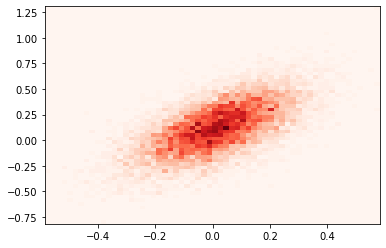

In [52]:
plt.hist2d(predictions[:,0], predictions[:,1], bins=(60,60),cmap=plt.cm.Reds)
plt.show()

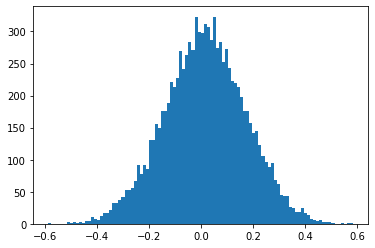

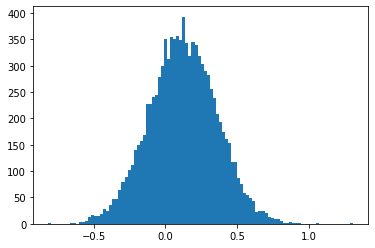

In [51]:
plt.hist(predictions[:,0], bins=100)
plt.show()
plt.hist(predictions[:,1], bins=100)
plt.show()

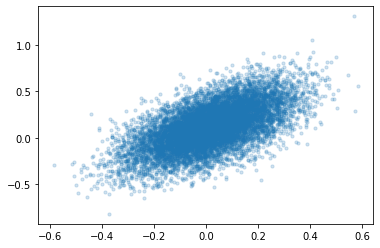

In [54]:
plt.scatter(predictions[:,0], predictions[:,1], s=10, alpha=0.2)